# Quarterback Passing Yards/Game Predictive Modeling

## Importing Passer Data

In [38]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [2]:
schedule = nfl.import_schedules([2024])

In [3]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [4]:
passer_data

,game_id,passer_player_name,posteam,defteam,season,week,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
4,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,11.0,NaN,-1.542538,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-63.542004,outdoors,grass
7,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,4.0,4.0,0.889353,1.0,0.0,0.0,0.0,0.0,0.0,8.0,24.549454,outdoors,grass
8,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,39.0,5.0,2.468265,1.0,0.0,0.0,0.0,0.0,0.0,44.0,71.269318,outdoors,grass
9,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,12.0,0.0,1.879388,1.0,0.0,0.0,0.0,0.0,1.0,12.0,53.646080,outdoors,grass
12,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,1.0,11.0,0.731470,1.0,0.0,0.0,0.0,0.0,0.0,12.0,19.861258,outdoors,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489400,2024_03_SF_LA,M.Stafford,LA,SF,2024,3,LA,SF,47.0,3.0,3.487897,1.0,0.0,0.0,0.0,0.0,0.0,50.0,66.415947,dome,
489407,2024_03_SF_LA,B.Purdy,SF,LA,2024,3,LA,SF,9.0,0.0,0.597428,1.0,0.0,0.0,0.0,0.0,0.0,9.0,29.741770,dome,
489408,2024_03_SF_LA,B.Purdy,SF,LA,2024,3,LA,SF,10.0,NaN,-0.310582,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-65.370537,dome,
489409,2024_03_SF_LA,B.Purdy,SF,LA,2024,3,LA,SF,31.0,NaN,-0.369712,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-34.778137,dome,


## Passer Preprocessing & Feature Engineering

In [5]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

In [6]:
# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [7]:
# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Drop the home_team and away_team columns
passer_df = passer_df.drop(columns=['home_team', 'away_team'])

In [8]:
# Reorder the columns
passer_df = passer_df[['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

In [9]:
# Calculate the exponentially weighted moving average for each feature
passer_df['completion_percentage_ewma'] = passer_df.groupby('passer_player_name')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_attempts_ewma'] = passer_df.groupby('passer_player_name')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['air_yards_ewma'] = passer_df.groupby('passer_player_name')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['yards_after_catch_ewma'] = passer_df.groupby('passer_player_name')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['epa_ewma'] = passer_df.groupby('passer_player_name')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['interception_ewma'] = passer_df.groupby('passer_player_name')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['qb_hit_ewma'] = passer_df.groupby('passer_player_name')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['sack_ewma'] = passer_df.groupby('passer_player_name')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_touchdown_ewma'] = passer_df.groupby('passer_player_name')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['passing_yards_ewma'] = passer_df.groupby('passer_player_name')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['cpoe_ewma'] = passer_df.groupby('passer_player_name')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [10]:
# Drop the non-ewma columns
passer_df = passer_df.drop(columns=['completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

## Defense Preprocessing & Feature Engineering

In [11]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

In [12]:
# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

In [13]:
# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [14]:
# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Drop the home_team and away_team columns
defense_df = defense_df.drop(columns=['home_team', 'away_team'])

In [15]:
# Reorder the columns
defense_df = defense_df[['defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

In [16]:
# Calculate the exponentially weighted moving average for each feature
defense_df['completion_percentage_ewma'] = defense_df.groupby('defteam')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_attempts_ewma'] = defense_df.groupby('defteam')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['air_yards_ewma'] = defense_df.groupby('defteam')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['yards_after_catch_ewma'] = defense_df.groupby('defteam')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['epa_ewma'] = defense_df.groupby('defteam')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['interception_ewma'] = defense_df.groupby('defteam')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['qb_hit_ewma'] = defense_df.groupby('defteam')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['sack_ewma'] = defense_df.groupby('defteam')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_touchdown_ewma'] = defense_df.groupby('defteam')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['passing_yards_ewma'] = defense_df.groupby('defteam')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['cpoe_ewma'] = defense_df.groupby('defteam')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [17]:
# Drop the non-ewma columns
defense_df = defense_df.drop(columns=['passing_yards','completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe'])

## Merging Passer & Defense Data

In [18]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_df.merge(defense_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))
# Get rid of flukey rows. Jury out on Taysom Hill I guess.
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8)]

filtered_with_ewma

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
0,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,173.0,False,21.0,outdoors,grass,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598,True,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598
1,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,349.0,True,47.0,outdoors,grass,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331,False,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331
2,2014_01_CAR_TB,D.Anderson,CAR,TB,2014,1,230.0,False,33.0,outdoors,grass,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589,True,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589
3,2014_01_CAR_TB,J.McCown,TB,CAR,2014,1,183.0,True,33.0,outdoors,grass,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191,False,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191
4,2014_01_CIN_BAL,A.Dalton,CIN,BAL,2014,1,301.0,False,38.0,outdoors,sportturf,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219,True,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6740,2024_03_NYG_CLE,D.Watson,CLE,NYG,2024,3,196.0,True,37.0,outdoors,,0.585567,36.518045,280.686607,75.669939,-14.460491,0.176062,12.612348,6.334401,1.450899,191.956103,-5.735928,False,0.605642,36.515345,259.507991,106.915696,-8.745106,0.003760,10.854524,5.883224,1.920080,225.801345,-3.816525
6741,2024_03_PHI_NO,D.Carr,NO,PHI,2024,3,142.0,True,24.0,dome,,0.641603,22.135776,164.744810,73.144393,4.597334,0.892073,3.049809,1.027544,1.460256,172.768078,-2.388715,False,0.599013,25.668588,206.226036,54.127601,-1.116676,0.889714,5.171198,1.944663,0.984111,152.040193,-5.206996
6742,2024_03_PHI_NO,J.Hurts,PHI,NO,2024,3,311.0,False,37.0,dome,,0.771150,34.502832,241.430646,161.594642,-2.350847,1.049550,6.304153,3.128736,0.404279,276.028508,9.806723,True,0.695370,37.702864,320.912077,165.116990,-4.428504,0.963885,6.015722,3.172964,0.356015,288.028137,3.377774
6743,2024_03_SF_LA,B.Purdy,SF,LA,2024,3,292.0,False,30.0,dome,,0.738309,31.253286,319.248695,57.281068,10.390618,0.231710,4.058320,2.192788,2.260245,292.181912,7.473561,True,0.685915,36.503721,334.530816,77.909885,8.116501,0.233649,3.678584,1.377913,2.063135,289.603465,2.527158


## Removing Outliers

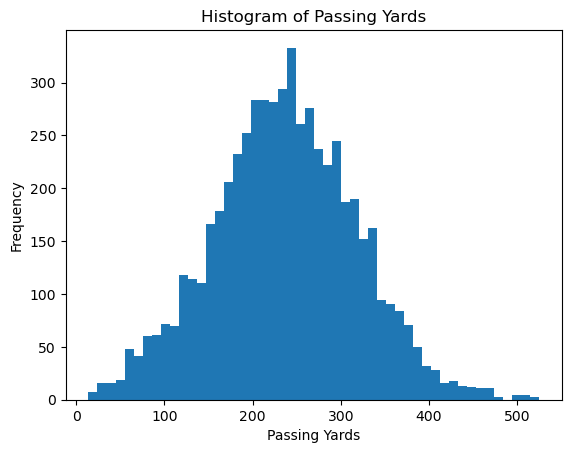

In [19]:
# Identify distribution shape to recreate after we get model results. This looks normal so using our projection for each QB for a week we will use RMSE
# as the standard deviation to create a normal distribution and assign a likelihood to each 
plt.hist(filtered_with_ewma['passing_yards'], bins=50)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards')
plt.show()

## Exploratory Data Analysis

In [20]:
# Get an overview of the data
filtered_with_ewma.describe().round(2)

,season,week,passing_yards,pass_attempts,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
count,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00,5741.00
mean,2018.67,9.52,236.78,32.16,0.66,31.83,264.10,108.45,0.90,0.75,5.05,2.22,1.46,234.67,0.19,0.66,33.75,280.69,114.51,0.55,0.83,5.41,2.39,1.53,247.68,0.21
std,2.95,5.44,81.29,9.17,0.08,7.51,79.37,36.97,8.03,0.65,2.17,1.27,0.89,66.67,7.00,0.07,5.83,69.65,31.44,7.98,0.68,2.03,1.25,0.82,53.66,6.23
min,2014.00,1.00,14.00,9.00,0.22,6.89,15.00,5.80,-29.73,0.00,0.00,0.00,0.00,22.00,-39.47,0.36,13.93,91.69,31.91,-27.07,0.00,0.00,0.00,0.00,81.57,-28.19
25%,2016.00,5.00,183.00,26.00,0.61,27.22,210.49,83.28,-4.45,0.23,3.49,1.26,0.82,192.18,-4.08,0.61,29.69,231.55,92.28,-4.66,0.25,3.98,1.47,0.92,209.59,-3.79
50%,2019.00,10.00,236.00,32.00,0.66,32.07,261.03,106.75,0.73,0.69,4.83,2.05,1.37,235.60,0.46,0.66,33.49,275.64,111.19,0.85,0.73,5.21,2.24,1.47,245.15,0.29
75%,2021.00,14.00,291.00,38.00,0.71,36.75,314.79,132.32,6.41,1.11,6.39,2.95,2.00,279.99,4.91,0.70,37.48,323.91,134.08,6.03,1.22,6.68,3.13,2.05,283.48,4.45
max,2024.00,22.00,525.00,67.00,1.00,61.00,603.72,250.26,26.29,4.15,14.94,8.25,5.52,483.02,23.10,0.89,61.00,627.07,244.09,27.12,4.01,14.39,8.42,4.96,458.00,20.70


## Modeling w/ Sci-kit Learn

maybe come back to the below cell and figure out how to transform these features into numerical values

In [21]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

In [22]:
# #running on everything to get best params, once I get params take them adn make new model holding out 
# X = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, features]
# y = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, target]

# # Select columns for one-hot encoding and standard scaling
# categorical_columns = ['roof', 'surface']
# numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# # Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_columns),
#         ('num', StandardScaler(), numeric_columns)
#     ])

# # Define the parameter grid for tuning
# param_grid = {
#     'num_leaves': [10, 20, 30, 40, 50],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 15],
#     'min_data_in_leaf': [10, 20, 30, 50, 100],
#     'min_split_gain': [0.0, 0.1, 0.2],
#     'subsample_for_bin': [20000, 30000, 40000],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'bagging_fraction': [0.7, 0.8, 0.9],
#     'feature_fraction': [0.7, 0.8, 0.9],
#     'lambda_l1': [0, 0.1, 0.5, 1],
#     'lambda_l2': [0, 0.1, 0.5, 1],
#     'scale_pos_weight': [1, 10, 20],  # for imbalanced datasets
#     'objective': ['regression'],
#     'boosting_type': ['gbdt', 'dart', 'goss'],  # try different boosting types
#     'n_estimators': [500, 1000, 1500],
#     'metric': ['rmse']
# }

# # Instantiate the LGBM model
# model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42)

# # Define the pipeline with preprocessing and the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', model)
# ])

# # Set up Bayesian Search using the pipeline
# opt = BayesSearchCV(
#     estimator=pipeline,  # Use the pipeline in Bayesian optimization
#     search_spaces={'regressor__' + k: v for k, v in param_grid.items()},  # Prefix params with 'regressor__'
#     n_iter=50,  # Number of iterations for Bayesian optimization
#     cv=3,
#     random_state=42,
#     verbose=1,
#     n_jobs=-1  # Use parallel processing
# )

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the Bayesian optimization search
# opt.fit(X_train, y_train)

# # Get the best parameters
# best_params = opt.best_params_

# # Save best parameters as a dictionary (without 'regressor__' prefix)
# cleaned_best_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

In [23]:
# Define the best parameters from Bayesian optimization
best_params = {
    'bagging_fraction': 0.7,
    'boosting_type': 'goss',
    'colsample_bytree': 0.9,
    'feature_fraction': 0.8,
    'lambda_l1': 1,
    'lambda_l2': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'metric': 'rmse',
    'min_data_in_leaf': 10,
    'min_split_gain': 0.2,
    'n_estimators': 1000,
    'num_leaves': 10,
    'objective': 'regression',
    'scale_pos_weight': 10,
    'subsample': 0.9,
    'subsample_for_bin': 30000
}


In [24]:
# Use data for all seasons before 2023 for training
X = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, features]
y = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, target]

In [25]:
# The data for 2024 that we will hold out for final testing
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
y_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, target]

In [26]:
# Ensure there are no missing values in X or y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Select columns for one-hot encoding and standard scaling
categorical_columns = ['roof', 'surface']
numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Instantiate the LGBM model with the best parameters
model = lgb.LGBMRegressor(**best_params, random_state=42, verbosity=-1)

# Define the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the model to all the data through 2023
pipeline.fit(X, y)

# Evaluate the model on the 2024 data
y_pred_2024 = pipeline.predict(X_2024)

# Print results (e.g., performance metrics)
print(f"2024 set performance: RMSE = {mean_squared_error(y_2024, y_pred_2024, squared=False)}")

2024 set performance: RMSE = 19.477997833237943


In [27]:
# Adding identifier columns back after filtering for 2024 data
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
X_2024 = X_2024.merge(filtered_with_ewma[['game_id', 'passer_player_name', 'posteam', 'week']], left_index=True, right_index=True)

In [35]:
# Assuming you have a column like 'game_id' that identifies each game
game_id_column = 'game_id'
passer_column = 'passer_player_name'
team_column = 'posteam'
week_column = 'week'

# Preprocess the 2024 data using the pipeline (no need to use 'preprocessor' step directly)
y_pred_2024 = pipeline.predict(X_2024)

# Create a DataFrame to store predictions along with the game identifier
pred_df = pd.DataFrame({
    game_id_column: X_2024[game_id_column].values,
    passer_column: X_2024[passer_column].values,            # Passer name (QB)
    team_column: X_2024[team_column].values,  # Get the game IDs from X_2024
    week_column: X_2024[week_column].values,  #Week
    'true_passing_yards': y_2024.values,                     # Actual target values
    'predicted_passing_yards': y_pred_2024                   # Predicted values
})

pred_df['pass_yards_oe'] = pred_df['true_passing_yards'] - pred_df['predicted_passing_yards']

In [36]:
pred_df.sort_values('pass_yards_oe', ascending = False)

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe
88,2024_03_NYG_CLE,D.Jones,NYG,3,236.0,192.849573,43.150427
86,2024_03_NE_NYJ,A.Rodgers,NYJ,3,281.0,238.680936,42.319064
24,2024_01_NYJ_SF,A.Rodgers,NYJ,1,167.0,131.392008,35.607992
67,2024_03_CAR_LV,A.Dalton,CAR,3,319.0,283.660822,35.339178
12,2024_01_HOU_IND,A.Richardson,IND,1,212.0,179.116377,32.883623
...,...,...,...,...,...,...,...
63,2024_02_TB_DET,B.Mayfield,TB,2,185.0,222.272121,-37.272121
78,2024_03_HOU_MIN,C.Stroud,HOU,3,215.0,252.377341,-37.377341
69,2024_03_CAR_LV,G.Minshew,LV,3,214.0,252.945481,-38.945481
36,2024_02_BUF_MIA,T.Tagovailoa,MIA,2,145.0,187.904577,-42.904577


In [37]:
pred_df.shape

(94, 7)

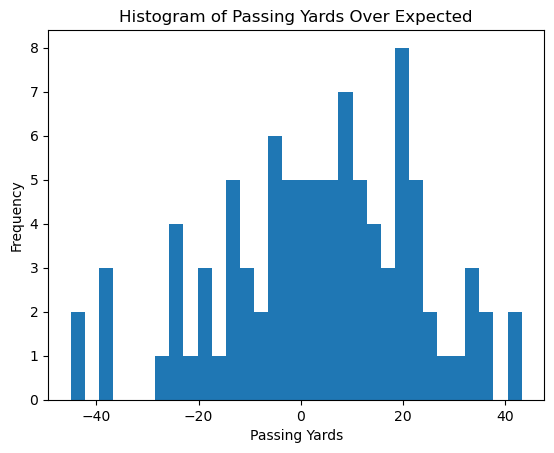

In [41]:
plt.hist(pred_df['pass_yards_oe'], bins=32)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards Over Expected')
plt.show()

#Chat GPT convo on boostrapping for distribution- use it!
#also- make sure we setup the span on EWMA's to be max(whateverbasedf['week']) to get proper span number that will increase with week. long term need to find a way to rerun weekly but that is so far away still lol

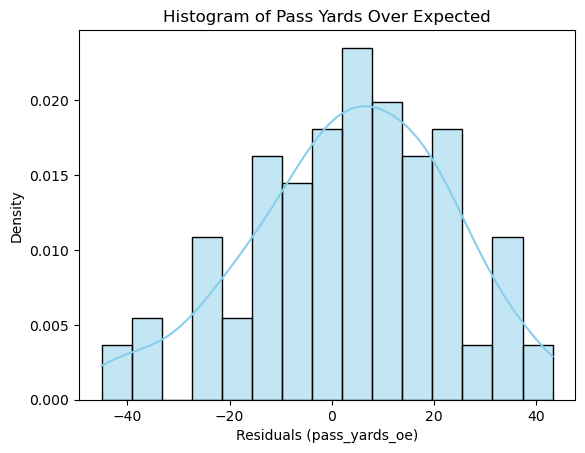

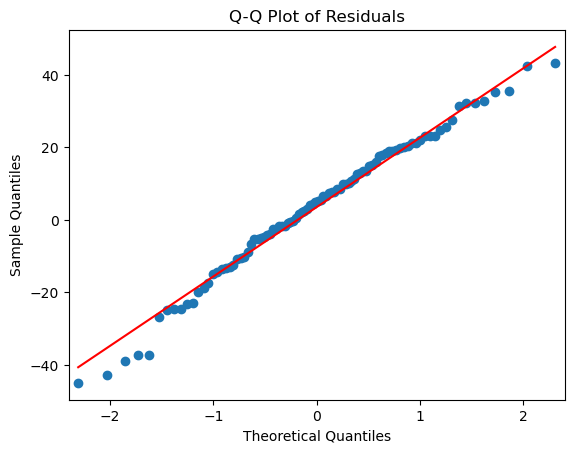

In [42]:
import statsmodels.api as sm

# Assuming 'residuals' is your numpy array of pass_yards_oe
residuals = pred_df['pass_yards_oe'].values

# Histogram and KDE
sns.histplot(residuals, bins=15, kde=True, stat='density', color='skyblue')
plt.title('Histogram of Pass Yards Over Expected')
plt.xlabel('Residuals (pass_yards_oe)')
plt.ylabel('Density')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [43]:
from scipy import stats

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test p-value: {shapiro_p}')

# Anderson-Darling Test for normality
anderson_result = stats.anderson(residuals, dist='norm')
print(f'Anderson-Darling Test Statistic: {anderson_result.statistic}')

# Kolmogorov-Smirnov Test against normal distribution
ks_stat, ks_p = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
print(f'Kolmogorov-Smirnov Test p-value: {ks_p}')

Shapiro-Wilk Test p-value: 0.3101855516433716
Anderson-Darling Test Statistic: 0.35045065429775946
Kolmogorov-Smirnov Test p-value: 0.9257697133870003


In [44]:
# Fit Normal Distribution
mu_norm, sigma_norm = stats.norm.fit(residuals)

# Fit Student's t-Distribution
df_t, loc_t, scale_t = stats.t.fit(residuals)

# Fit Skew-Normal Distribution
shape_skew, loc_skew, scale_skew = stats.skewnorm.fit(residuals)

# Fit Laplace Distribution
loc_laplace, scale_laplace = stats.laplace.fit(residuals)

In [51]:
def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

def calculate_bic(n_params, log_likelihood, n_samples):
    return np.log(n_samples) * n_params - 2 * log_likelihood

n = len(residuals)

# Normal Distribution
loglik_norm = np.sum(stats.norm.logpdf(residuals, mu_norm, sigma_norm))
aic_norm = calculate_aic(2, loglik_norm)
bic_norm = calculate_bic(2, loglik_norm, n)

# t-Distribution
loglik_t = np.sum(stats.t.logpdf(residuals, df_t, loc_t, scale_t))
aic_t = calculate_aic(3, loglik_t)
bic_t = calculate_bic(3, loglik_t, n)

# Skew-Normal Distribution
loglik_skew = np.sum(stats.skewnorm.logpdf(residuals, shape_skew, loc_skew, scale_skew))
aic_skew = calculate_aic(3, loglik_skew)
bic_skew = calculate_bic(3, loglik_skew, n)

# Laplace Distribution
loglik_laplace = np.sum(stats.laplace.logpdf(residuals, loc_laplace, scale_laplace))
aic_laplace = calculate_aic(2, loglik_laplace)
bic_laplace = calculate_bic(2, loglik_laplace, n)

# Compare AIC and BIC
print('AIC Values:')
print(f'Normal: {aic_norm}, t-Distribution: {aic_t}, Skew-Normal: {aic_skew}, Laplace: {aic_laplace}')

print('BIC Values:')
print(f'Normal: {bic_norm}, t-Distribution: {bic_t}, Skew-Normal: {bic_skew}, Laplace: {bic_laplace}')

#lower is better for both

AIC Values:
Normal: 825.858862368173, t-Distribution: 827.8590658390193, Skew-Normal: 825.2682756790705, Laplace: 834.4014966544589
BIC Values:
Normal: 830.945451932713, t-Distribution: 835.4889501858294, Skew-Normal: 832.8981600258805, Laplace: 839.4880862189989


In [48]:
from scipy.stats import skew

skewness = skew(residuals)
print(f'Skewness of residuals: {skewness}')

Skewness of residuals: -0.3634183114535324


In [52]:
#we are starting with normal, which like damn bro come on

In [53]:
# Calculate the standard deviation of the residuals
residual_std = np.std(pred_df['pass_yards_oe'], ddof=1)  # ddof=1 ensures it's the sample standard deviation
print(f"Standard Deviation of Residuals: {residual_std}")

Standard Deviation of Residuals: 19.259391363406717
